In [3]:
import numpy as np
import os, shutil
import cv2
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from torchvision import transforms as T

C:\Users\Andaman\AppData\Local\Temp\ipykernel_13276\1835756201.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import Model

In [27]:
def try_load_weight(model, model_name, checkpoint):
    weight_key = [key for key in list(checkpoint.keys()) if 'state_dict' in key and 'model' in key][0]
    try:
        print(f'Loading {model_name} weights')
        model.load_state_dict(checkpoint[weight_key])
    except:
        print("My Model : Need DataParallel")
        model = nn.DataParallel(model)
        model.load_state_dict(checkpoint[weight_key])
    print('==============================================================================')
    model = model.cuda()
    model = model.eval()

for model_type in os.listdir('results/'):
    print(f"==============={model_type}===============")
    for m in os.listdir(f"results/{model_type}"):
        print(m)

===============DoubleUNet===============
DoubleUNet_test
===============ResUNet===============
ResUNet-baseline
ResUNet-PReLU
ResUNet-t2
===============ResUNetMultiConnection===============
ResUNetMC-baseline
sample_w_1-10
===============UNet===============
baseline
UNet-64F
UNet-PReLU-Cond-512P
UNet-PReLU-Cond-512P-64F
===============UNetMultiConnection===============
UNetMC
UNetMC-CondCrop-512P
UNetMC-PReLU-Cond-512P
UNetMC-ReLU-Cond-512P


In [29]:
import my_network.network as network
from my_network.UNetMultiConnection import UNetMultiConnection
from my_network.DoubleUNet import DoubleUNet
from my_network.UNet import UNet
from my_network.CustomUNet import CustomUNet
from my_network.ResUNet import ResUNet
from my_network.ResUNetMultiConnection import ResUNetMultiConnection
import torch
from torch import nn


num_img_ch = 1
num_classes = 2
num_features = 32

model_path_list = [
                   'ResUNet/ResUNet-baseline',
                  ]
checkpoint_list = [torch.load(f'results/{model_path}/model.pth', map_location='cuda') for model_path in model_path_list]


models_list = []
models_type_list = []
for i, model_path in enumerate(model_path_list):
    model_type = model_path.split('/')[0]
    
#     if i == 1:
#         model_type = 'CustomUNet'
    
#     if model_type == 'UNet':
#         models_list.append(UNet(in_channels=checkpoint_list[i]['config'].num_img_ch,
#                                 out_channels=checkpoint_list[i]['config'].num_classes,
#                                 num_features=checkpoint_list[i]['config'].num_features))
    if model_type == 'UNet':
        models_list.append(CustomUNet(in_channels =checkpoint_list[i]['config'].num_img_ch,
                                      out_channels=checkpoint_list[i]['config'].num_classes,
                                      num_features=checkpoint_list[i]['config'].num_features))
    elif model_type == 'UNetMultiConnection':
        models_list.append(UNetMultiConnection(in_channels=1,
                                               out_channels=2,
                                               num_features=32))
    elif model_type == 'DoubleUNet':
        models_list.append(DoubleUNet(in_channels=1, freeze_vgg=True))
    elif model_type == 'ResUNet':
        models_list.append(ResUNet(in_channels =checkpoint_list[i]['config'].num_img_ch,
                                   out_channels=checkpoint_list[i]['config'].num_classes,
                                   num_features=checkpoint_list[i]['config'].num_features))
    elif model_type =='ResUNetMultiConnection':
        models_list.append(ResUNetMultiConnection(in_channels =checkpoint_list[i]['config'].num_img_ch,
                                                  out_channels=checkpoint_list[i]['config'].num_classes,
                                                  num_features=checkpoint_list[i]['config'].num_features))
    else:
        raise NotImplementedError(f"Model {model_type} is not implemented")
    
    try_load_weight(models_list[i], model_type, checkpoint_list[i])
    models_type_list.append(model_type)




# Load Baseline Model
baseline_checkpoint = torch.load('results/UNet/baseline/model.pth')
baseline_model = network.UNet(in_channels=baseline_checkpoint['config'].num_img_ch,
                              out_channels=baseline_checkpoint['config'].num_classes,
                              num_features=baseline_checkpoint['config'].num_features)
try:
    print(f'Loading Baseline UNet weights')
    baseline_model.load_state_dict(baseline_checkpoint['model_UNet_state_dict'])
except:
    print("Baseline : Need DataParallel")
    baseline_model = nn.DataParallel(baseline_model)
    baseline_model.load_state_dict(baseline_checkpoint['model_UNet_state_dict'])
baseline_model.eval()
baseline_model.cuda()



print('Passed')
print('...')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Baseline model has {count_parameters(baseline_model):,} trainable parameters')
for i, model in enumerate(models_list):
    print(f'Model {models_type_list[i]:30}: {count_parameters(model):10,} trainable parameters')

Loading ResUNet weights
My Model : Need DataParallel
Loading Baseline UNet weights
Baseline : Need DataParallel
Passed
...
Baseline model has 232,162 trainable parameters
Model ResUNet                       : 11,576,655 trainable parameters


In [43]:
image_list = sorted(os.listdir('polar_stent_dataset/image/test'))
th = 0.5

if os.path.exists('figures'):
    shutil.rmtree('figures')
os.makedirs('figures')


for index, image_name in tqdm(enumerate(image_list), total=len(image_list)):
    image = Image.open(f'polar_stent_dataset/image/test/{image_name}')
    image = np.array(image).astype(np.float32) / 255.0
    image = image / np.std(image)
    image = T.ToTensor()(np.array(image))
    
    label = Image.open(f'polar_stent_dataset/label/test/{image_name}')
    label = np.array(label).astype(np.float32) / 255.0
    label = T.ToTensor()(np.array(label))
    
    image = image.to('cuda')

    output = models_list[0](image.unsqueeze(0))[0][1].detach().cpu()
    output = np.where(output > th, 255, 0)
    
    saved_name = model_path_list[0].replace('/', '_')
    cv2.imwrite(f'predictions/{image_name}',output)



    


  0%|          | 0/152 [00:00<?, ?it/s]

# SKLEARN - Contour Detection

In [1]:
from skimage.measure import label, regionprops, regionprops_table
from pylab import rcParams
rcParams['figure.figsize'] = 20,6

In [ ]:
# label_image = label(cart_pred, connectivity=None)
# pred_regions = regionprops(label_image)
# print(f"Detected {len(pred_regions)} stents... (Predicted)")

# label_image = label(cart_label, connectivity=None)
# label_regions = regionprops(label_image)
# print(f"Detected {len(label_regions)} stents... (Label)")

# label_image = label(org_label, connectivity=None)
# org_label_regions = regionprops(label_image)
# print(f"Detected {len(label_regions)} stents... (Original Label)")

In [14]:
image_folder_dir = 'predictions/'
image_list = os.listdir(image_folder_dir)

th_distance = 9.77 / 1.4421
# th_distance = 30

precision = []
recall = []

for i, image_name in tqdm(enumerate(image_list), total=len(image_list)):
    image_path = os.path.join(image_folder_dir, image_name)
    label_path = image_path.replace('predictions', 'polar_stent_dataset/label/test')
    # org_label_path = image_path.replace('predictions', 'stent_dataset/valid/mask')

    polar_pred = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    polar_label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    # org_label = cv2.imread(org_label_path, cv2.IMREAD_GRAYSCALE)

    cart_pred = cv2.linearPolar(polar_pred.T, (512,512), 484, cv2.WARP_INVERSE_MAP)
    cart_label = cv2.linearPolar(polar_label.T, (512,512), 484, cv2.WARP_INVERSE_MAP)
    
    pred_regions = regionprops(label(cart_pred, connectivity=None))
    label_regions = regionprops(label(cart_label, connectivity=None))
    
    total_pred = len(pred_regions)
    total_label = len(label_regions)
    
    TP = 0
    for props in pred_regions:
        y0, x0 = props.centroid
        candidate = None
        min_distance = th_distance
        for label_props in label_regions:
            yl, xl = label_props.centroid

            distance = np.sqrt(np.power(x0-xl, 2) + np.power(y0-yl, 2))
            
            if distance < min_distance:
                min_distance = distance
                candidate = label_props
                
        if candidate is not None:
            TP += 1
            label_regions.remove(candidate)

    try:
        precision.append(TP/total_pred)
        recall.append(TP/total_label)
    except:
        print(f"Warning : Zero Division at {image_name}")

print(f"Mean Precision : {np.mean(precision)}")
print(f"Mean Recall    : {np.mean(recall)}")

  0%|          | 0/152 [00:00<?, ?it/s]

Mean Precision : 0.9461172716172715
Mean Recall    : 0.9095305038099155


In [10]:
precision[0]

0.8461538461538461

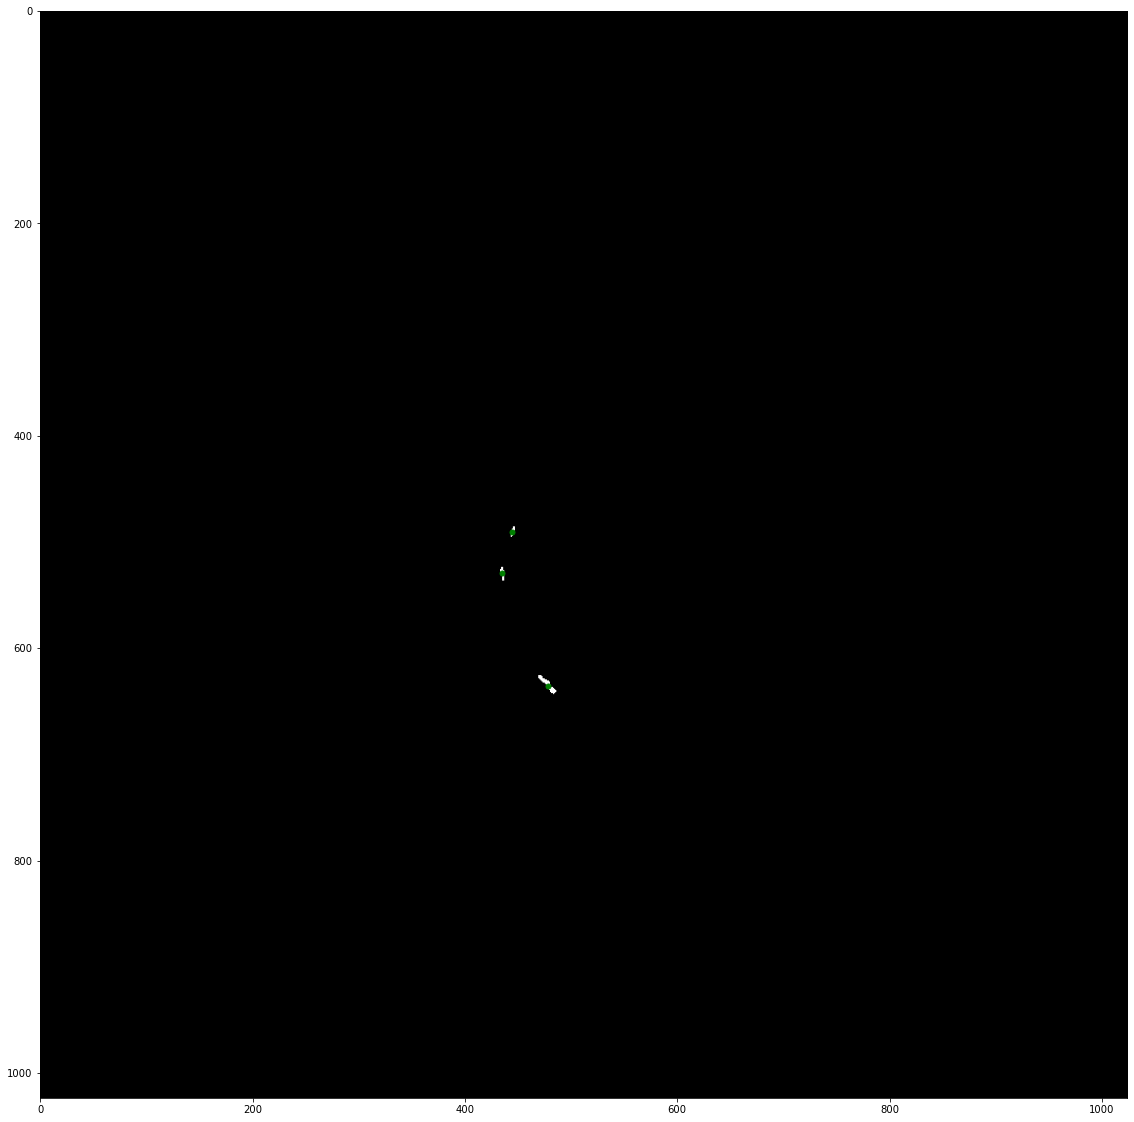

In [134]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(cart_label, cmap=plt.cm.gray)

for props in pred_regions:
    y0, x0 = props.centroid

#     ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
#     ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=10)

#     minr, minc, maxr, maxc = props.bbox
#     bx = (minc, maxc, maxc, minc, minc)
#     by = (minr, minr, maxr, maxr, minr)
#     ax.plot(bx, by, '-b', linewidth=2.5)

# ax.axis((0, 600, 600, 0))

plt.show()

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

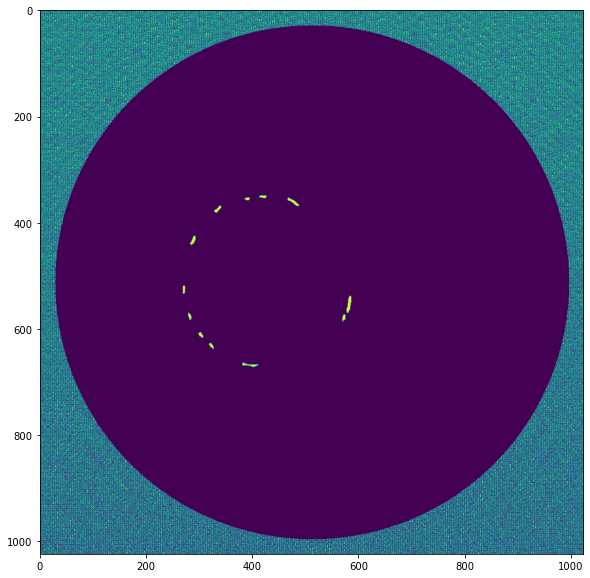

In [21]:
img = cv2.imread('img_test22.bmp', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

In [44]:
mask1 = np.zeros_like(img)
mask1 = cv2.circle(mask1, (512,512), 483, (255,255,255), -1)

In [45]:
new_img = cv2.bitwise_and(mask1, img)

In [89]:
from skimage.measure import regionprops, label

old_region = regionprops(label(img))
new_region = regionprops(label(new_img))
print(len(old_region))
print(len(new_region))

231896
12


In [96]:
newnew_img = cv2.cvtColor(new_img, cv2.COLOR_GRAY2RGB)

for re in new_region:
    x,y = re.centroid
    newnew_img = cv2.circle(newnew_img, (int(y), int(x)), 2, (255,0,0), -1)


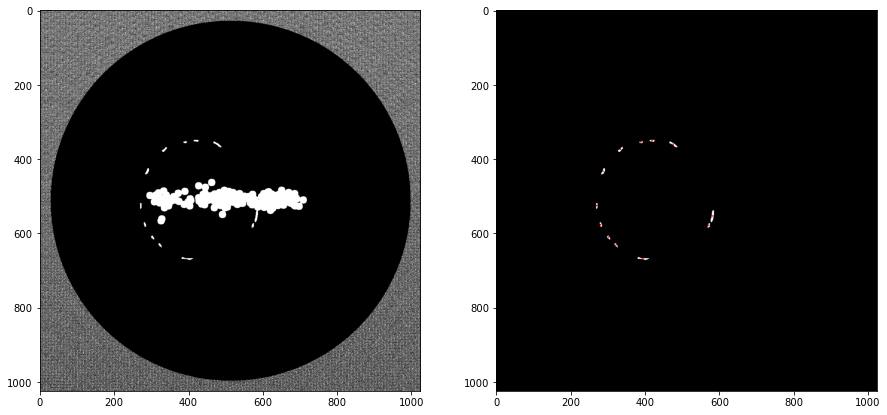

In [97]:
fig,ax = plt.subplots(1,2, figsize=(15,15))

ax[0].imshow(img, cmap='gray')
ax[1].imshow(newnew_img)

In [115]:
l = np.arange(0,101)
 
for i in l:
    print(f"\rPercent = {i}", end='')
    time.sleep(0.5)

Percent = 100

In [129]:
params = {
    'num_features': 64,
    'optimizer': "Adam",
    'n_unit': 2
}

score = dict(precision=0.7, recall=0.8, f1=0.88)

add = dict(params=params, score=score)

str(add)

"{'params': {'num_features': 64, 'optimizer': 'Adam', 'n_unit': 2}, 'score': {'precision': 0.7, 'recall': 0.8, 'f1': 0.88}}"

In [127]:
logfile_name = 'gasss.txt'

lines = [str(params)]

with open(f'{logfile_name}', 'a+') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

with open(f'{logfile_name}', 'a+') as f:
    for line in lines:
        f.write(line)
        f.write('\n')